In [1]:
import pandas as pd
import numpy as np
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
import pprint
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# import apartment info from mongodb
db = client['apartments']
table = db['main_pages']

In [3]:
table.count_documents({})

586

In [4]:
apartment_collection = table.find()

In [5]:
#create new dataframe with just headers
df_columns = ['listing_id', 'property_name', 'address', 'mean_rent', 'mean_area', 'walkscore']
df = pd.DataFrame(columns=df_columns)

In [7]:
# for each apartment in collection parse html and 
# find the following info in collection 
# [name, address, price or price range, area, and Walkscore] 
# and add to Pandas DF
for apartment in apartment_collection:
    soup = BeautifulSoup(apartment['html'], 'html.parser')
    
    listing_id = apartment['listing_id']
    property_name = soup.find('h1', 'propertyName').text.strip()
    address_ = soup.find('div', 'propertyAddress').find('h2').text
    address = ' '.join(address_.split())
    
    # iterate through each unit and find mean price and area
    max_rents = []
    unit_areas = []
    for unit in soup.find('table', 'availabilityTable').find('tbody').find_all('tr', 'rentalGridRow'):
        availability = unit.find('td', 'available').text.strip()
        # only look at max rents for simplicity
        unit_max_rent = unit['data-maxrent']
        if (availability == 'Available Now') and (unit_max_rent != ''):
            max_rents.append(int(unit_max_rent))
        else:
            break
        unit_area_str = unit.find('td', 'sqft').text.strip(' Sq Ft')
        try:
            unit_area_range = unit_area_str.replace(',', '').split(' - ')
            unit_area_range = [int(area) for area in unit_area_range]
            unit_area = (max(unit_area_range) + min(unit_area_range)) / 2
            unit_areas.append(unit_area)
        except:
            print('area problem: {}'.format(address))
            
    mean_rent = 0
    mean_area = 0
    try:
        mean_rent = sum(max_rents) / len(max_rents)
    except:
        print('Rent problem: {}'.format(address))
        
    try:
        mean_area = sum(unit_areas) / len(unit_areas)
    except:
        print('area problem: {}'.format(address))
        
    
    walkscore = int(soup.find('div', 'ratingCol walkScore').find('span', 'score').text)
    
    #add info to DF
    row = pd.DataFrame([[listing_id, 
                         property_name, 
                         address, 
                         mean_rent, 
                         mean_area, 
                         walkscore]], columns=df_columns)
    df = df.append(row, ignore_index=True)
    
    

Rent problem: 2704 Rio Grande St, Austin, TX 78705
Rent problem: 110 San Antonio St, Austin, TX 78701
Rent problem: 2810 Hemphill Park, Austin, TX 78705
Rent problem: 2815 Guadalupe St, Austin, TX 78705
Rent problem: 13005 Heinemann Dr, Austin, TX 78727
Rent problem: 1600 Wickersham Ln, Austin, TX 78741
Rent problem: 1300 Crossing Pl, Austin, TX 78741
Rent problem: 1833 Cheddar Loop, Austin, TX 78728
Rent problem: 1301 Crossing Pl, Austin, TX 78741
Rent problem: 1901 Mariposa Dr, Austin, TX 78741
Rent problem: 1500 E Riverside Dr, Austin, TX 78741
Rent problem: 5501 Ross Rd, Del Valle, TX 78617
Rent problem: 507 W 23rd St, Austin, TX 78705
Rent problem: 1114 Camino La Costa, Austin, TX 78752
Rent problem: 3603 Southridge Dr, Austin, TX 78704
Rent problem: 1801 Wells Branch Pky, Austin, TX 78728
Rent problem: 2101 Rio Grande, Austin, TX 78705
Rent problem: 400 W Anderson Ln, Austin, TX 78752
Rent problem: 615 Wonsley Dr E, Austin, TX 78753
Rent problem: 1016 Camino La Costa, Austin, TX 

In [8]:
df

,listing_id,property_name,address,mean_rent,mean_area,walkscore
0,rdsyjd0,The District on La Frontera,"2811 La Frontera Blvd, Austin, TX 78728",2130.714286,1232.0,12
1,vsvz28g,Cliffs at Barton Creek,"3050 Tamarron Blvd, Austin, TX 78746",2585.545455,1392.0,39
2,pfzryrs,Radius On Grove,"2301 Grove Blvd, Austin, TX 78741",1604.000000,1298.0,34
3,lb7xscf,Chandelier,"2336 Douglas St, Austin, TX 78741",1274.333333,892.0,47
4,b5qxnw9,Fivetwo At Highland,"110 Jacob Fontaine Lane, Austin, TX 78752",2005.674419,1355.0,54
...,...,...,...,...,...,...
580,zspjkkx,Altis Lakeline,"12700 Ridgeline Blvd, Cedar Park, TX 78613",0.000000,1086.0,42
581,l8esygf,300 Bowie St Unit 2904,"Austin, TX 78703",1995.000000,565.0,96
582,w4ex40j,617 Peacock Ln,"Austin, TX 78704",2950.000000,1766.0,60
583,6vvhrpr,6500 Adair Dr,"Austin, TX 78754",1650.000000,1636.0,3


In [14]:
df = df[df['mean_rent'] != 0]

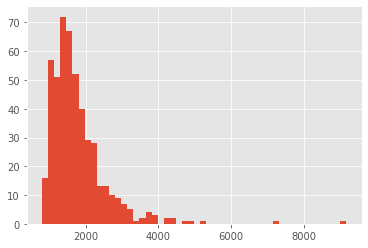

In [15]:
y = df['mean_rent']
plt.hist(df['mean_rent'], bins=50);

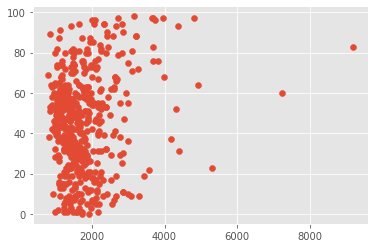

In [16]:
# scatter plot showing no correlation betwee rent and walkscore
plt.scatter(df['mean_rent'], df['walkscore'])

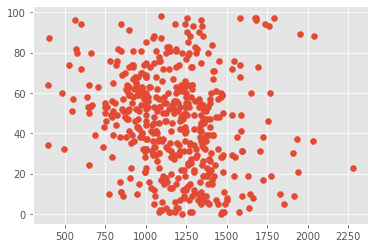

In [18]:
# scatter plot maybe showing very weak negative correlation between unit area and walkscore
plt.scatter(df['mean_area'], df['walkscore'])

In [ ]:
# Create column for cost/SF

# Create column for some metric comparing cost/SF and Walkscore. 
# Maybe it's the ((cost/SF) / Walkscore)

In [27]:
df['cost/SF'] = (df['mean_rent'] / df['mean_area'])
df.sort_values(by='cost/SF')


,listing_id,property_name,address,mean_rent,mean_area,walkscore,cost/SF
257,6v748nv,Texan26,"1009 W 26th St, Austin, TX 78705",851.500000,1954.0,89,0.435773
332,f2rgb7s,Hilltop,"2402 San Gabriel St, Austin, TX 78705",1429.583333,1759.0,93,0.812725
303,bj014wb,The Terrace at Walnut Creek,"8712 Old Manor Rd, Austin, TX 78724",1240.666667,1485.0,1,0.835466
346,bq2mdkc,Polaris on the Park,"1710-1720 Woodward St, Austin, TX 78741",1124.000000,1344.0,49,0.836310
531,j81y3r7,River Valley Apartments,"810 E Slaughter Ln, Austin, TX 78744",1240.250000,1480.0,21,0.838007
...,...,...,...,...,...,...,...
541,1hc86x6,La Hacienda Resort & Cottages,"5220 Hudson Bend Rd, Austin, TX 78734",1595.800000,399.0,34,3.999499
90,56q2bdm,Lenox Boardwalk,"2515 Elmont Dr, Austin, TX 78741",4916.437500,1216.0,64,4.043123
445,j5v1qd5,Terrazzo,"8585 Spicewood Springs Rd, Austin, TX 78759",4311.875000,1002.0,52,4.303268
46,mdgjmyk,Mosaic at Mueller,"4600 Mueller Blvd, Austin, TX 78723",7224.680000,1650.0,60,4.378594


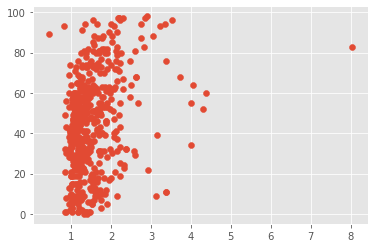

In [24]:
plt.scatter(df['cost/SF'], df['walkscore']);